##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Convolutional Neural Network (CNN)

Although IBM’s Deep Blue supercomputer beat the chess world champion Garry Kasparov back in 1996, it wasn’t until fairly recently that computers were able to reliably perform seemingly trivial tasks such as detecting a puppy in a picture or recognizing spoken words. Why are these tasks so effortless to us humans? The answer lies in the fact that perception largely takes place outside the realm of our consciousness, within specialized visual, auditory, and other sensory modules in our brains. By the time sensory information reaches our consciousness, it is already adorned with high-level features; for example, when you look at a picture of a cute puppy, you cannot choose not to see the puppy, not to notice its cuteness. Nor can you explain how you recognize a cute puppy; it’s just obvious to you. Thus, we cannot trust our subjective experience: perception is not trivial at all, and to understand it we must look at how our sensory modules work.

https://www.tensorflow.org/tutorials/images/cnn

This tutorial demonstrates training a simple [Convolutional Neural Network](https://developers.google.com/machine-learning/glossary/#convolutional_neural_network) (CNN) to classify [CIFAR images](https://www.cs.toronto.edu/~kriz/cifar.html). Because this tutorial uses the [Keras Sequential API](https://www.tensorflow.org/guide/keras/overview), creating and training your model will take just a few lines of code.


_Convolutional neural networks_ (CNNs) emerged from the study of the brain’s visual cortex, and they have been used in computer image recognition since the 1980s. Over the last 10 years, thanks to the increase in computational power, the amount of available training data, and the tricks presented in Chapter 11 for training deep nets, CNNs have managed to achieve superhuman performance on some complex visual tasks. They power image search services, self-driving cars, automatic video classification systems, and more. Moreover, CNNs are not restricted to visual perception: they are also successful at many other tasks, such as voice recognition and natural language processing. However, we will focus on visual applications for now.

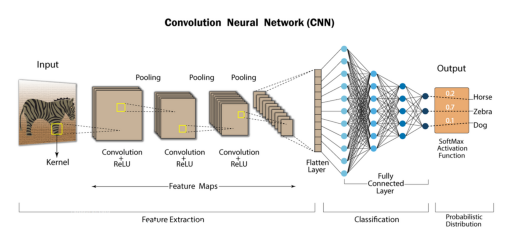

In [2]:
from PIL import Image
import matplotlib.pyplot as plt
plt.grid(False)
plt.axis("off")
img = Image.open('images\cnn_image.png')
plt.imshow(img)

The most important building block of a CNN is the convolutional layer. Neurons in the first convolutional layer are not connected to every single pixel in the input image (like they were in the networks we have discussed previously), but only to pixels in their receptive fields. In turn, each neuron in the second convolutional layer is connected only to neurons located within a small rectangle in the first layer. This architecture allows the network to concentrate on small low-level features in the first hidden layer, then assemble them into larger higher-level features in the next hidden layer, and so on. 

This hierarchical structure is common in real-world images, which is one of the reasons why CNNs work so well for image recognition.

All the multilayer neural networks we’ve looked at so far had layers composed of a long line of neurons, and we had to flatten input images to 1D before feeding them to the neural network. In a CNN each layer is represented in 2D, which makes it easier to match neurons with their corresponding inputs.

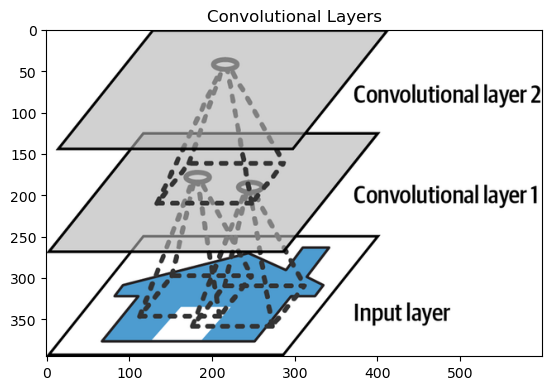

In [3]:
img = Image.open('images/cnn_layers.png')
plt.title('Convolutional Layers')
plt.imshow(img)

A neuron located in row i, column j of a given layer is connected to the outputs of the neurons in the previous layer located in rows i to i + fh – 1, columns j to j + fw – 1, where fh and fw are the height and width of the receptive field. In order for a layer to have the same height and width as the previous layer, it is common to add zeros around the inputs, as shown in the diagram. This is called _zero padding_.

It is also possible to connect a large input layer to a much smaller layer by spacing out the receptive fields, as shown below. This dramatically reduces the model’s computational complexity. The horizontal or vertical step size from one receptive field to the next is called the _stride_. In the diagram, a 5 × 7 input layer (plus zero padding) is connected to a 3 × 4 layer, using 3 × 3 receptive fields and a stride of 2 (in this example the stride is the same in both directions, but it does not have to be). A neuron located in row i, column j in the upper layer is connected to the outputs of the neurons in the previous layer located in rows i × sh to i × sh + fh – 1, columns j × sw to j × sw + fw – 1, where sh and sw are the vertical and horizontal strides.

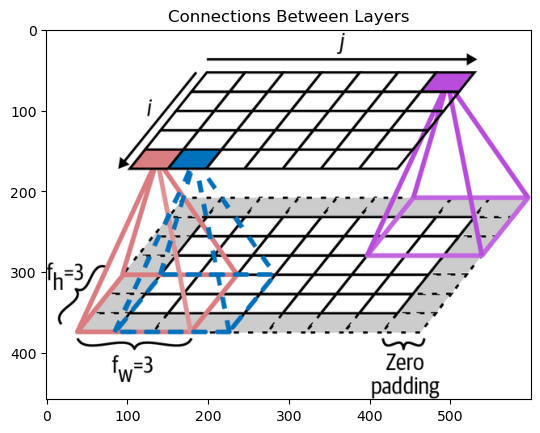

In [4]:
img = Image.open('images/cnn_padding.png')
plt.title('Connections Between Layers')
plt.imshow(img)

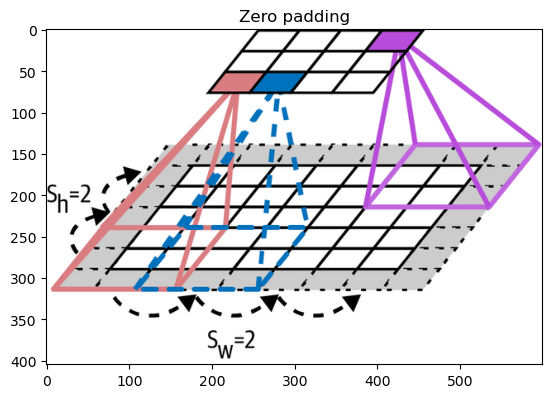

In [5]:
img = Image.open('images/cnn_stride.png')
plt.title('Zero padding')
plt.imshow(img)

A neuron’s weights can be represented as a small image the size of the receptive field. For example, the next figure shows two possible sets of weights, called _filters_ (or _convolution kernels_, or just _kernels_). The first one is represented as a black square with a vertical white line in the middle (it’s a 7 × 7 matrix full of 0s except for the central column, which is full of 1s); neurons using these weights will ignore everything in their receptive field except for the central vertical line (since all inputs will be multiplied by 0, except for the ones in the central vertical line). The second filter is a black square with a horizontal white line in the middle. Neurons using these weights will ignore everything in their receptive field except for the central horizontal line.

If all neurons in a layer use the same vertical line filter (and the same bias term), and you feed the network the input image shown below (the bottom image), the layer will output the top-left image. Notice that the vertical white lines get enhanced while the rest gets blurred. Similarly, the upper-right image is what you get if all neurons use the same horizontal line filter; notice that the horizontal white lines get enhanced while the rest is blurred out. Thus, a layer full of neurons using the same filter outputs a _feature map_, which highlights the areas in an image that activate the filter the most. But don’t worry, you won’t have to define the filters manually: instead, during training the convolutional layer will automatically learn the most useful filters for its task, and the layers above will learn to combine them into more complex patterns.

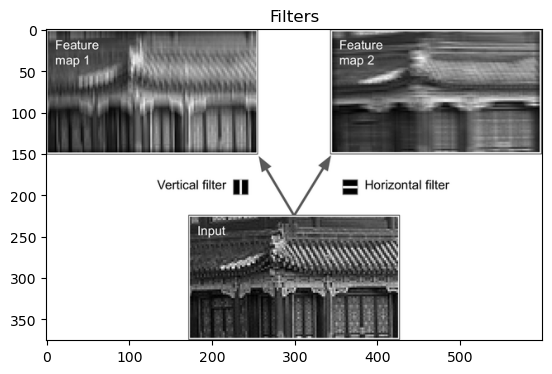

In [6]:
img = Image.open('images/cnn_filters.png')
plt.title('Filters')
plt.imshow(img)

Up to now, for simplicity, we have represented the output of each convolutional layer as a 2D layer, but in reality a convolutional layer has multiple filters (you decide how many) and each layer outputs one feature map per filter, so it is more accurately represented in 3D. It has one neuron per pixel in each feature map, and all neurons within a given feature map share the same parameters (i.e., the same kernel and bias term). Neurons in different feature maps use different parameters. A neuron’s receptive field is the same as described earlier, but it extends across all the feature maps of the previous layer. 

In short, a convolutional layer simultaneously applies multiple trainable filters to its inputs, making it capable of detecting multiple features anywhere in its inputs. The fact that all neurons in a feature map share the same parameters dramatically reduces the number of parameters in the model. Once the CNN has learned to recognize a pattern in one location, it can recognize it in any other location. In contrast, once a fully connected neural network has learned to recognize a pattern in one location, it can only recognize it in that particular location.

Input images are also composed of multiple sublayers: one per color channel. For images, there are typically three: red, green, and blue (RGB). Grayscale images have just one channel, but some images may have many more—for example, satellite images that capture extra light frequencies (such as infrared).

Specifically, a neuron located in row i, column j of the feature map k in a given convolutional layer l is connected to the outputs of the neurons in the previous layer l – 1, located in rows i × sh to i × sh + fh – 1 and columns j × sw to j × sw + fw – 1, across all feature maps (in layer l – 1). Note that, within a layer, all neurons located in the same row i and column j but in different feature maps are connected to the outputs of the exact same neurons in the previous layer.

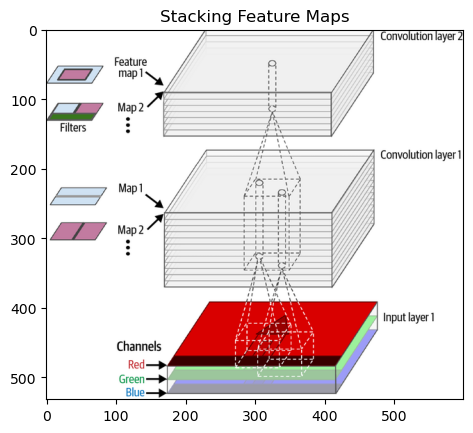

In [7]:
img = Image.open('images/cnn_stackingmaps.png')
plt.title('Stacking Feature Maps')
plt.imshow(img)

Once you understand how convolutional layers work, the pooling layers are quite easy to grasp. Their goal is to subsample (i.e., shrink) the input image in order to reduce the computational load, the memory usage, and the number of parameters (thereby limiting the risk of overfitting).

Just like in convolutional layers, each neuron in a pooling layer is connected to the outputs of a limited number of neurons in the previous layer, located within a small rectangular receptive field. You must define its size, the stride, and the padding type, just like before. However, a pooling neuron has no weights; all it does is aggregate the inputs using an aggregation function such as the max or mean. The next image shows a _max pooling layer_, which is the most common type of pooling layer. 

In this example, we use a 2 × 2 pooling kernel,⁠ with a stride of 2 and no padding. Only the max input value in each receptive field makes it to the next layer, while the other inputs are dropped. For example, in the lower-left receptive field in Figure 14-9, the input values are 1, 5, 3, 2, so only the max value, 5, is propagated to the next layer. Because of the stride of 2, the output image has half the height and half the width of the input image (rounded down since we use no padding).

A pooling layer typically works on every input channel independently, so the output depth (i.e., the number of channels) is the same as the input depth.

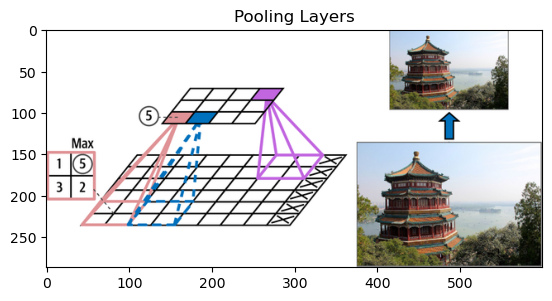

In [8]:
img = Image.open('images/cnn_pooling.png')
plt.title('Pooling Layers')
plt.imshow(img)

Other than reducing computations, memory usage, and the number of parameters, a max pooling layer also introduces some level of invariance to small translations, as shown in the image below. Here we assume that the bright pixels have a lower value than dark pixels, and we consider three images (A, B, C) going through a max pooling layer with a 2 × 2 kernel and stride 2. Images B and C are the same as image A, but shifted by one and two pixels to the right. As you can see, the outputs of the max pooling layer for images A and B are identical. This is what translation invariance means. For image C, the output is different: it is shifted one pixel to the right (but there is still 50% invariance). By inserting a max pooling layer every few layers in a CNN, it is possible to get some level of translation invariance at a larger scale. Moreover, max pooling offers a small amount of rotational invariance and a slight scale invariance. Such invariance (even if it is limited) can be useful in cases where the prediction should not depend on these details, such as in classification tasks.

However, max pooling has some downsides too. It’s obviously very destructive: even with a tiny 2 × 2 kernel and a stride of 2, the output will be two times smaller in both directions (so its area will be four times smaller), simply dropping 75% of the input values. And in some applications, invariance is not desirable. Take semantic segmentation (the task of classifying each pixel in an image according to the object that pixel belongs to, which we’ll explore later in this chapter): obviously, if the input image is translated by one pixel to the right, the output should also be translated by one pixel to the right. The goal in this case is equivariance, not invariance: a small change to the inputs should lead to a corresponding small change in the output.

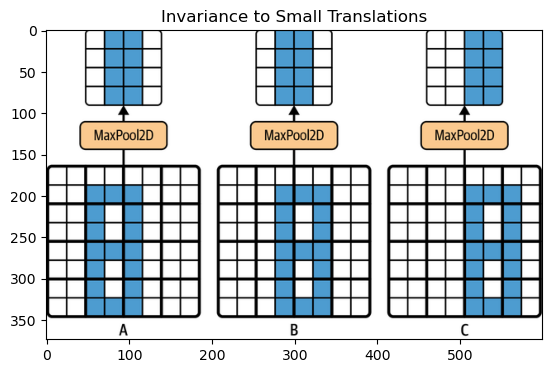

In [9]:
img = Image.open('images/cnn_maxpool2d.png')
plt.title('Invariance to Small Translations')
plt.imshow(img)

It's also possible to create an _average pooling layer_. As you might expect, it works exactly like a max pooling layer, except it computes the mean rather than the max. Average pooling layers used to be very popular, but people mostly use max pooling layers now, as they generally perform better. This may seem surprising, since computing the mean generally loses less information than computing the max. But on the other hand, max pooling preserves only the strongest features, getting rid of all the meaningless ones, so the next layers get a cleaner signal to work with. Moreover, max pooling offers stronger translation invariance than average pooling, and it requires slightly less compute.

Note that max pooling and average pooling can be performed along the depth dimension instead of the spatial dimensions, although it’s not as common. This can allow the CNN to learn to be invariant to various features. For example, it could learn multiple filters, each detecting a different rotation of the same pattern (such as handwritten digits; see Figure 14-11), and the depthwise max pooling layer would ensure that the output is the same regardless of the rotation. The CNN could similarly learn to be invariant to anything: thickness, brightness, skew, color, and so on.

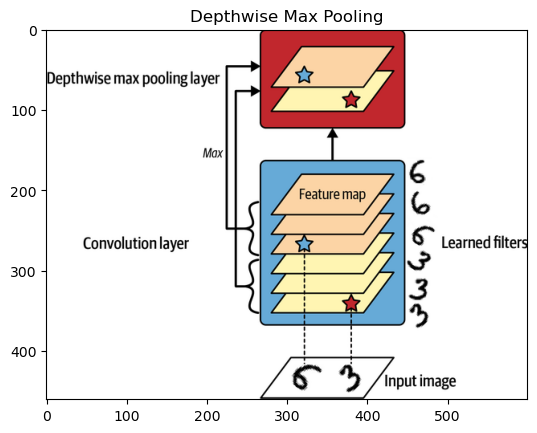

In [10]:
img = Image.open('images/cnn_depthwise_max.png')
plt.title('Depthwise Max Pooling')
plt.imshow(img)

Typical CNN architectures stack a few convolutional layers (each one generally followed by a ReLU layer), then a pooling layer, then another few convolutional layers (+ReLU), then another pooling layer, and so on. 

The image gets smaller and smaller as it progresses through the network, but it also typically gets deeper and deeper (i.e., with more feature maps), thanks to the convolutional layers. At the top of the stack, a regular feedforward neural network is added, composed of a few fully connected layers (+ReLUs), and the final layer outputs the prediction (e.g., a softmax layer that outputs estimated class probabilities).

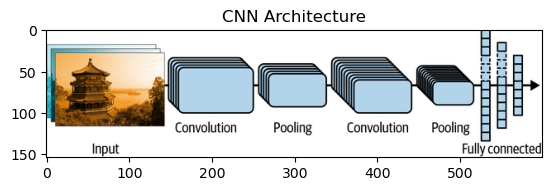

In [11]:
img = Image.open('images/cnn_architecture.png')
plt.title('CNN Architecture')
plt.imshow(img)

### Import TensorFlow

In [12]:
import tensorflow as tf

from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

### Download and prepare the CIFAR10 dataset


The CIFAR10 dataset contains 60,000 color images in 10 classes, with 6,000 images in each class. The dataset is divided into 50,000 training images and 10,000 testing images. The classes are mutually exclusive and there is no overlap between them.

In [13]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

### Verify the data

To verify that the dataset looks correct, let's plot the first 25 images from the training set and display the class name below each image:


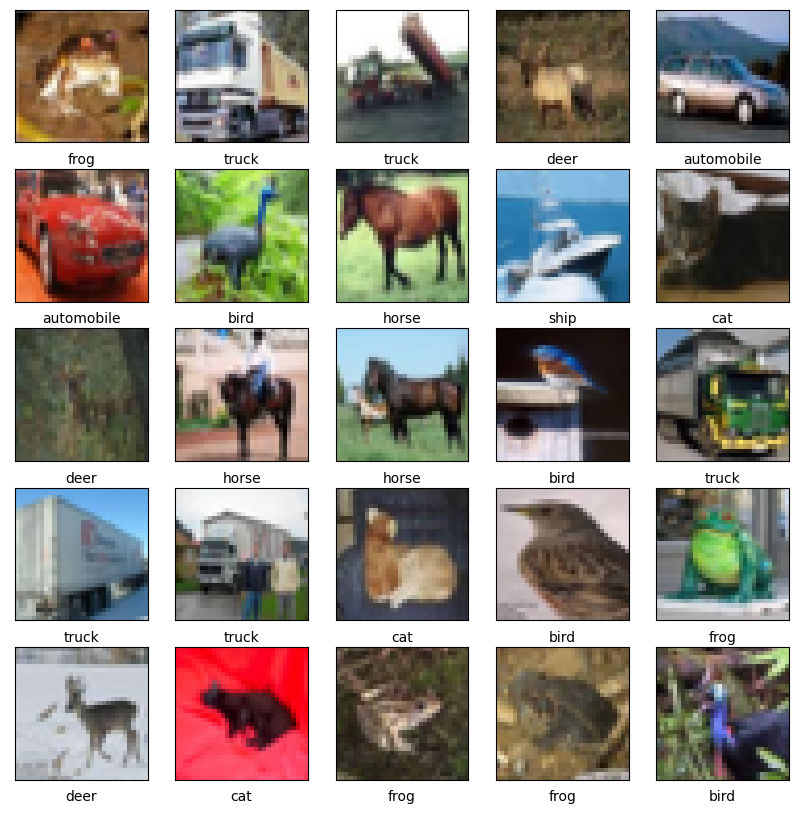

In [14]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

### Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of [Conv2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) and [MaxPooling2D](https://www.tensorflow.org/api_docs/python/tf/keras/layers/MaxPool2D) layers.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color_channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32, 32, 3), which is the format of CIFAR images. You can do this by passing the argument `input_shape` to your first layer.


In [15]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))

Let's display the architecture of your model so far:

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
Total params: 56,320
Trainable params: 56,320
Non-traina

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically,  as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

### Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D,  then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs.

In [17]:
model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

Here's the complete architecture of your model:

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

The network summary shows that (4, 4, 64) outputs were flattened into vectors of shape (1024) before going through two Dense layers.

### Compile and train the model

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Epoch 1/10
1563/1563 [==============================] - 31s 20ms/step - loss: 1.5123 - accuracy: 0.4491 - val_loss: 1.3157 - val_accuracy: 0.5367
Epoch 2/10
1563/1563 [==============================] - 30s 19ms/step - loss: 1.1519 - accuracy: 0.5921 - val_loss: 1.1250 - val_accuracy: 0.5989
Epoch 3/10
1563/1563 [==============================] - 31s 20ms/step - loss: 1.0062 - accuracy: 0.6469 - val_loss: 1.0212 - val_accuracy: 0.6406
Epoch 4/10
1563/1563 [==============================] - 31s 20ms/step - loss: 0.9186 - accuracy: 0.6773 - val_loss: 0.9902 - val_accuracy: 0.6511
Epoch 5/10
1563/1563 [==============================] - 31s 20ms/step - loss: 0.8517 - accuracy: 0.7020 - val_loss: 0.9421 - val_accuracy: 0.6769
Epoch 6/10
1563/1563 [==============================] - 31s 20ms/step - loss: 0.7963 - accuracy: 0.7227 - val_loss: 0.8833 - val_accuracy: 0.6959
Epoch 7/10
1563/1563 [==============================] - 31s 20ms/step - loss: 0.7493 - accuracy: 0.7392 - val_loss: 0.8969 -

### Evaluate the model

313/313 - 1s - loss: 0.8869 - accuracy: 0.7068 - 1s/epoch - 4ms/step


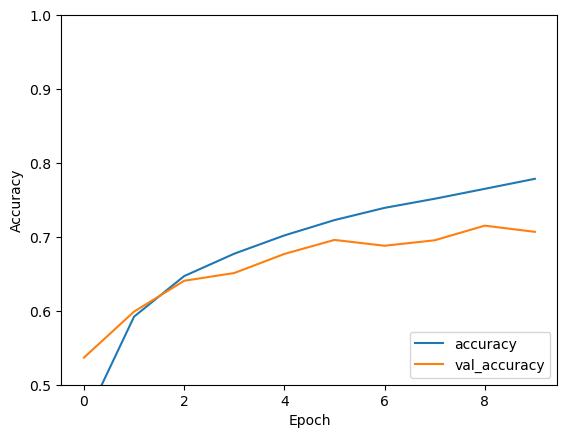

In [20]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

In [21]:
print(test_acc)

0.7067999839782715


Your simple CNN has achieved a test accuracy of over 70%. Not bad for a few lines of code! For another CNN style, check out the [TensorFlow 2 quickstart for experts](https://www.tensorflow.org/tutorials/quickstart/advanced) example that uses the Keras subclassing API and `tf.GradientTape`.